
## 루브릭 평가 기준

### CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다


### 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함


### 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
 
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

필요한 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

GPU체크

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation을 적용한 데이터셋 만들기

데이터셋 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


데이터 확인

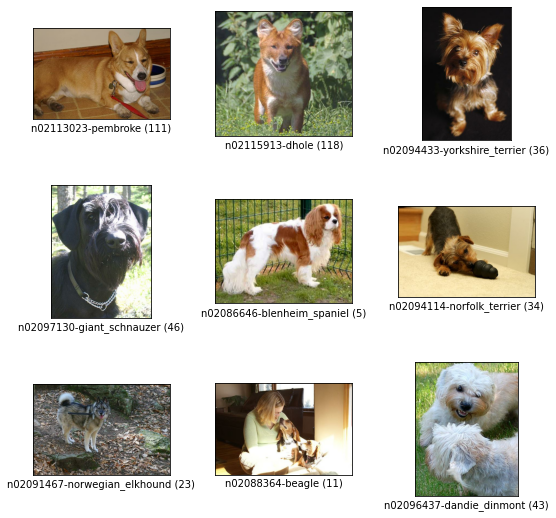

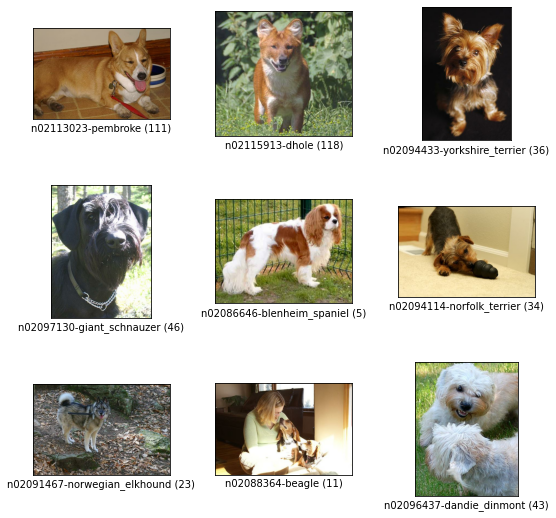

In [4]:
tfds.show_examples(ds_train, ds_info)

#### 기본 Augmentation 적용


이미지 사이즈 재설정

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

이미지 좌우 반전과 밝기 조절 Augmentation

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image, label

언제든 적용을 할 수 있는 메인 함수 apply_normalize_on_dataset 만들기

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)


####  CutMix Augmentation
 
- CutMix 이름처럼, 이미지 데이터를 자르고 섞는 방식입니다.


- 배치 내의 이미지를 2개 고른 후, 바운딩 박스의 위치를 랜덤하게 선택한 후 해당 영역을 자른 뒤 2개의 이미지를 섞기 때문에 새롭게 만들어진 이미지는 2개의 label을 갖게 됩니다.

- 그러면, new label은 전체 이미지 대비 섞인 이미지의 비율 계산 후 면적에 비례해서 섞어주기 입니다.



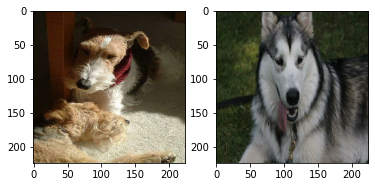

In [9]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

새로운 이미지의 2개의 label

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(74, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


이미지 섞기

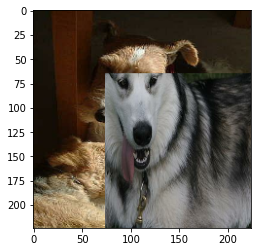

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

레이블 섞기

In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.52467316, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [13]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 1.4 Mixup

- 2개의 서로 다른 이미지의 픽셀별 값을 비율에 따라서 섞는 방식


- 2개의 이미지를 섞을 비율을 일정한 범위에서 랜덤하게 추출한 후, 추출된 비율 값에 따라서 두 이미지의 픽셀별 값과 label을 섞어준다


- 앞에서 사용한 CutMix 방식은 두 이미지의 일부를 잘라 합치는 방식이었다면, 해당 Mixup 방식은 두 이미지를 자르지 않고 픽셀별로 합치는 방식입니다.

In [14]:
num_classes = ds_info.features["label"].num_classes

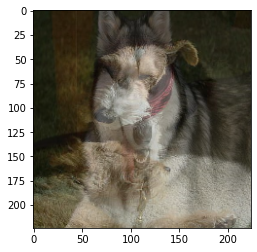

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.50433993 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.49566007 0.         

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 1.5 데이터셋 만들기

- CutMix, Mixup 방식은  categorical_crossentropy()를 사용한다.


- 이는 CutMix, Mixup 방식이 이미지뿐만 아니라, label도 mix가 된 형태이므로 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터의 형태로 변환되었기 때문이다.


- 그러므로 label을 One-Hot 벡터로 표현할 수 있도록 만들어주는 코드가 필요하다.

One-hot벡터 표현해주기

In [17]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

위의 과정과 동일

In [18]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,
                               with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)


ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)



ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 만들기

In [20]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


In [21]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [25]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기

In [28]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 358s 436ms/step - loss: 3.2154 - accuracy: 0.2796 - val_loss: 3.2263 - val_accuracy: 0.2270
Epoch 2/20
750/750 [==============================] - 328s 437ms/step - loss: 0.8953 - accuracy: 0.7532 - val_loss: 1.0375 - val_accuracy: 0.6962
Epoch 3/20
750/750 [==============================] - 329s 439ms/step - loss: 0.2559 - accuracy: 0.9484 - val_loss: 0.9537 - val_accuracy: 0.7271
Epoch 4/20
750/750 [==============================] - 330s 439ms/step - loss: 0.0727 - accuracy: 0.9939 - val_loss: 0.9192 - val_accuracy: 0.7381
Epoch 5/20
750/750 [==============================] - 329s 439ms/step - loss: 0.0316 - accuracy: 0.9984 - val_loss: 0.9448 - val_accuracy: 0.7362
Epoch 6/20
750/750 [==============================] - 330s 441ms/step - loss: 0.0183 - accuracy: 0.9999 - val_loss: 0.9736 - val_accuracy: 0.7299
Epoch 7/20
750/750 [==============================] - 330s 440ms/step - loss: 0.0322 - accuracy: 0.9977 - val_loss: 1.0198 -

In [29]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 336s 441ms/step - loss: 3.2409 - accuracy: 0.2692 - val_loss: 3.2407 - val_accuracy: 0.2264
Epoch 2/20
750/750 [==============================] - 330s 440ms/step - loss: 1.1019 - accuracy: 0.6852 - val_loss: 1.1936 - val_accuracy: 0.6502
Epoch 3/20
750/750 [==============================] - 329s 439ms/step - loss: 0.6346 - accuracy: 0.8235 - val_loss: 1.1071 - val_accuracy: 0.6817
Epoch 4/20
750/750 [==============================] - 329s 439ms/step - loss: 0.3330 - accuracy: 0.9188 - val_loss: 1.0405 - val_accuracy: 0.7020
Epoch 5/20
750/750 [==============================] - 329s 439ms/step - loss: 0.1679 - accuracy: 0.9642 - val_loss: 1.1336 - val_accuracy: 0.6934
Epoch 6/20
750/750 [==============================] - 329s 439ms/step - loss: 0.0973 - accuracy: 0.9848 - val_loss: 0.9902 - val_accuracy: 0.7236
Epoch 7/20
750/750 [==============================] - 330s 440ms/step - loss: 0.0544 - accuracy: 0.9933 - val_loss: 0.9348 -

In [32]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 339s 443ms/step - loss: 4.3780 - accuracy: 0.1053 - val_loss: 3.2112 - val_accuracy: 0.2375
Epoch 2/20
750/750 [==============================] - 331s 441ms/step - loss: 3.1327 - accuracy: 0.3819 - val_loss: 1.3220 - val_accuracy: 0.6221
Epoch 3/20
750/750 [==============================] - 331s 441ms/step - loss: 2.8128 - accuracy: 0.4652 - val_loss: 1.2655 - val_accuracy: 0.6481
Epoch 4/20
750/750 [==============================] - 330s 441ms/step - loss: 2.6361 - accuracy: 0.5225 - val_loss: 1.3616 - val_accuracy: 0.6256
Epoch 5/20
750/750 [==============================] - 331s 441ms/step - loss: 2.4781 - accuracy: 0.5817 - val_loss: 1.3732 - val_accuracy: 0.6242
Epoch 6/20
750/750 [==============================] - 330s 441ms/step - loss: 2.3555 - accuracy: 0.6105 - val_loss: 1.3334 - val_accuracy: 0.6397
Epoch 7/20
750/750 [==============================] - 331s 441ms/step - loss: 2.2708 - accuracy: 0.6443 - val_loss: 1.3715 -

In [33]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 338s 442ms/step - loss: 4.2982 - accuracy: 0.1315 - val_loss: 3.5640 - val_accuracy: 0.1974
Epoch 2/20
750/750 [==============================] - 331s 441ms/step - loss: 3.0344 - accuracy: 0.4161 - val_loss: 1.5041 - val_accuracy: 0.5826
Epoch 3/20
750/750 [==============================] - 331s 441ms/step - loss: 2.7528 - accuracy: 0.5138 - val_loss: 1.6104 - val_accuracy: 0.5632
Epoch 4/20
750/750 [==============================] - 331s 442ms/step - loss: 2.5679 - accuracy: 0.5790 - val_loss: 1.2421 - val_accuracy: 0.6553
Epoch 5/20
750/750 [==============================] - 331s 441ms/step - loss: 2.4379 - accuracy: 0.6302 - val_loss: 1.3343 - val_accuracy: 0.6362
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 2.3018 - accuracy: 0.6681 - val_loss: 1.2026 - val_accuracy: 0.6625
Epoch 7/20
750/750 [==============================] - 331s 441ms/step - loss: 2.2390 - accuracy: 0.7122 - val_loss: 1.4425 -

## 4. 훈련 과정 시각화하기

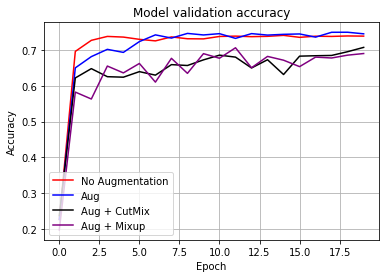

In [37]:
plt.plot(history_resnet50.history['val_accuracy'], 'red')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'blue')

plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'black')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'purple')


plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Aug', 'Aug + CutMix', 'Aug + Mixup'], loc='lower left')

plt.grid(True)
plt.show()

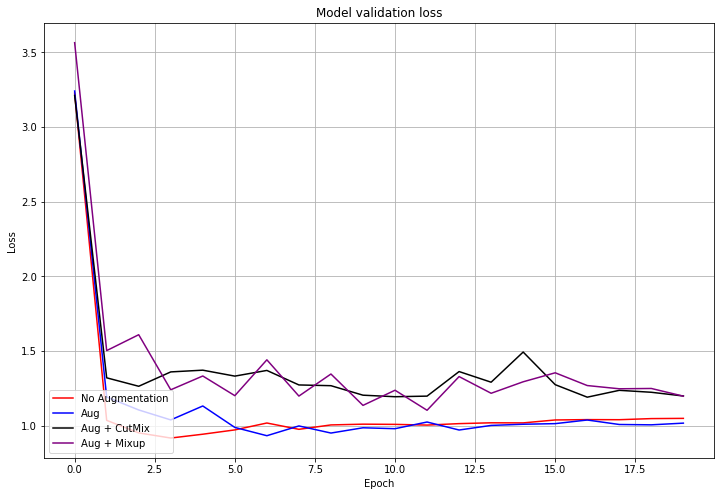

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50.history['val_loss'], 'red')
plt.plot(history_resnet50_aug.history['val_loss'], 'blue')


plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'black')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'purple')



plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Aug', 'Aug + CutMix', 'Aug + Mixup'], loc='lower left')

plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

표를 이용해서 한 눈의 보여드리도록 하겠습니다.

In [41]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50.history['val_accuracy'], 
            'Aug': history_resnet50_aug.history['val_accuracy'], 
            'Aug + CutMix': history_resnet50_aug_cutmix.history['val_accuracy'], 
            'Aug + Mixup': history_resnet50_aug_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,Aug,Aug + CutMix,Aug + Mixup
0,0.227029,0.226446,0.237523,0.197411
1,0.696245,0.650187,0.622085,0.582556
2,0.727145,0.681670,0.648088,0.563200
3,0.738106,0.701959,0.625583,0.655317
4,0.736241,0.693447,0.624184,0.636194
5,0.729944,0.723647,0.639692,0.662547
6,0.725630,0.742421,0.629897,0.610424
7,0.736707,0.733442,0.659282,0.676889
8,0.731577,0.746502,0.656833,0.634911
9,0.731227,0.742188,0.672575,0.689949


##  회고


제가 분석한 논문과 실험결과가 맞는지에 대해서 초점을 두고 서술했습니다.

<논문내용1>

No augmentation은 epcoh가 진행이 될 수록 과적합이 일어나기 때문에 최적화 기법 중 하나인 Augmentation을 이용하면 과적합 문제를 해결할 수 있을 것이다. 그리고 적용을 하면 성능 향상 또한 일어날 것이다.

<실제 실험결과1>

Augmentation을 적용하지 않았을 때보다, 적용했을 때 모델의 성능이 향상된 것을 확인할 수 있었다. 

그리고, augmentation을 적용하지 않은 모델의 경우 약 10~11 epoch까지는 accuracy가 증가하지만, 이후에는 감소하다가 다시 증가하는 경향을 보이는 것으로 보아, 11 epoch 이후에 overfitting의 가능성이 예측이됩니다,

반대로, augmentation을 적용한 모델은 약 12 epoch에서 모델의 성능이 가장 높았고, 적용하지 않은 모델에서 과적합이 일어난 부분을 잘 해결하여 성능 향상을 일으킨 것 같으나 이후 epoch에서는 overfitting의 가능성을 배제할 수는 없는 것이 augmentation을 한다고 해서 과적합이 안 일어나는 것은 아니기 때문입니다.


<실험 결과2>


학습하기 전 예상으로는 CutMix와 Mixup을 적용한 모델이 더 높은 accuracy를 보일 것으로 예상했는데, 그렇지 못한 것으로 보인다.

그 이유는 우리는 여러 성능이 좋은 모델을 합성하면 드라마틱한 결과를 낼 것 같지만, 실제로는 많은 적용으로 인해서 발생하는 노이즈로 인해서 제대로된 학습이 되지 못하는 경우가 더 많습니다.

고로, 위와 같은 결과가 나온 것 같습니다.



---

<개인적인 생각과 아쉬움>


CutMix와 Mixup을 동시에 적용시킨 모델의 성능도 궁금해서 진행을 해보려고 했으나, 학습 시간이 너무 많이 소요됨에 따라서, 노드 제출 기간에 진행하지 못할 것 같아서 못한 것이 아쉽습니다.

방학 때, 모든 모델을 다 돌려볼 계획입니다.

사실, augmentation 논문 을 보기 전에는 정말 환상에 사로잡혔다. 데이터가 없고 과적합이 일어나면 augmentation은 마치 치트키라고 생각을 했기 때문입니다. 허나 실제 논문과 실험결과를 보면 augmentation효과가 있지만 우리의 생각보다는 미미할 수 밖에 없을 겁니다.

그 이유는 단순 노이즈를 추가해서 모델의 성능을 올리기에는 역부족이기 때문입니다. 

그래서 논문에서도 augmentation의 성능이 좋다라고 말하기 보단, augmentation을 이용하면 만든 nerual net을 통해서 학습한 모델의 성능이 좋을 거라고 말하는 것으로 보아 보조제는 될 수 있지만 핵심이 될 수 없는 것이 데이터 증가기법의 한계라면 한계이고 특징이라면 특징인 것 같습니다.


